In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.simplefilter("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import *
from sklearn.svm import SVC
from sklearn.metrics import *
import shap
import lime.lime_tabular
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from IPython.display import YouTubeVideo
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/eligibility-prediction-for-loan/Loan_Data.csv


In [2]:
loan = pd.read_csv("/kaggle/input/eligibility-prediction-for-loan/Loan_Data.csv")
loan.drop("Loan_ID",axis=1, inplace=True)
loan.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
#show the last 10 rows
loan.tail(10)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
604,Female,Yes,1,Graduate,No,12000,0.0,496.0,360.0,1.0,Semiurban,Y
605,Male,Yes,0,Not Graduate,No,2400,3800.0,NaN,180.0,1.0,Urban,N
606,Male,Yes,1,Graduate,No,3400,2500.0,173.0,360.0,1.0,Semiurban,Y
607,Male,Yes,2,Not Graduate,No,3987,1411.0,157.0,360.0,1.0,Rural,Y
608,Male,Yes,0,Graduate,No,3232,1950.0,108.0,360.0,1.0,Rural,Y
609,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y
613,Female,No,0,Graduate,Yes,4583,0.0,133.0,360.0,0.0,Semiurban,N


In [4]:
# to view the dimension(rows,colums)
loan.shape

(614, 12)

In [5]:
# View the statistical summary of the dataset. Thisonly works with numerical datatypes
loan.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [6]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     564 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 57.7+ KB


<Axes: title={'center': 'Missing values in each column'}>

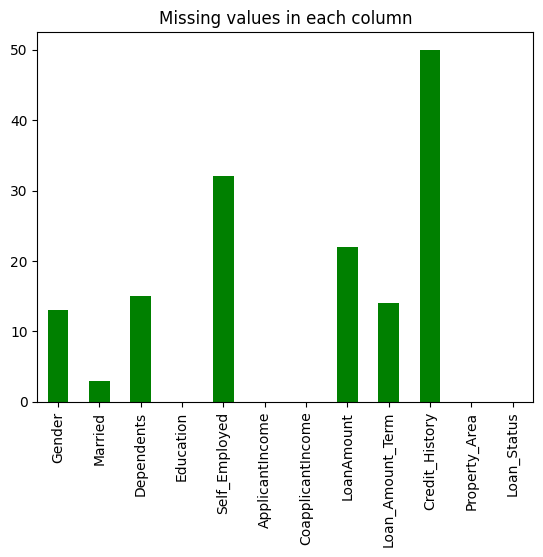

In [7]:
#Check for missing data and plot it in a bar chart
loan.isnull().sum().plot(kind="bar",
                         color= "green",
                         title= "Missing values in each column")

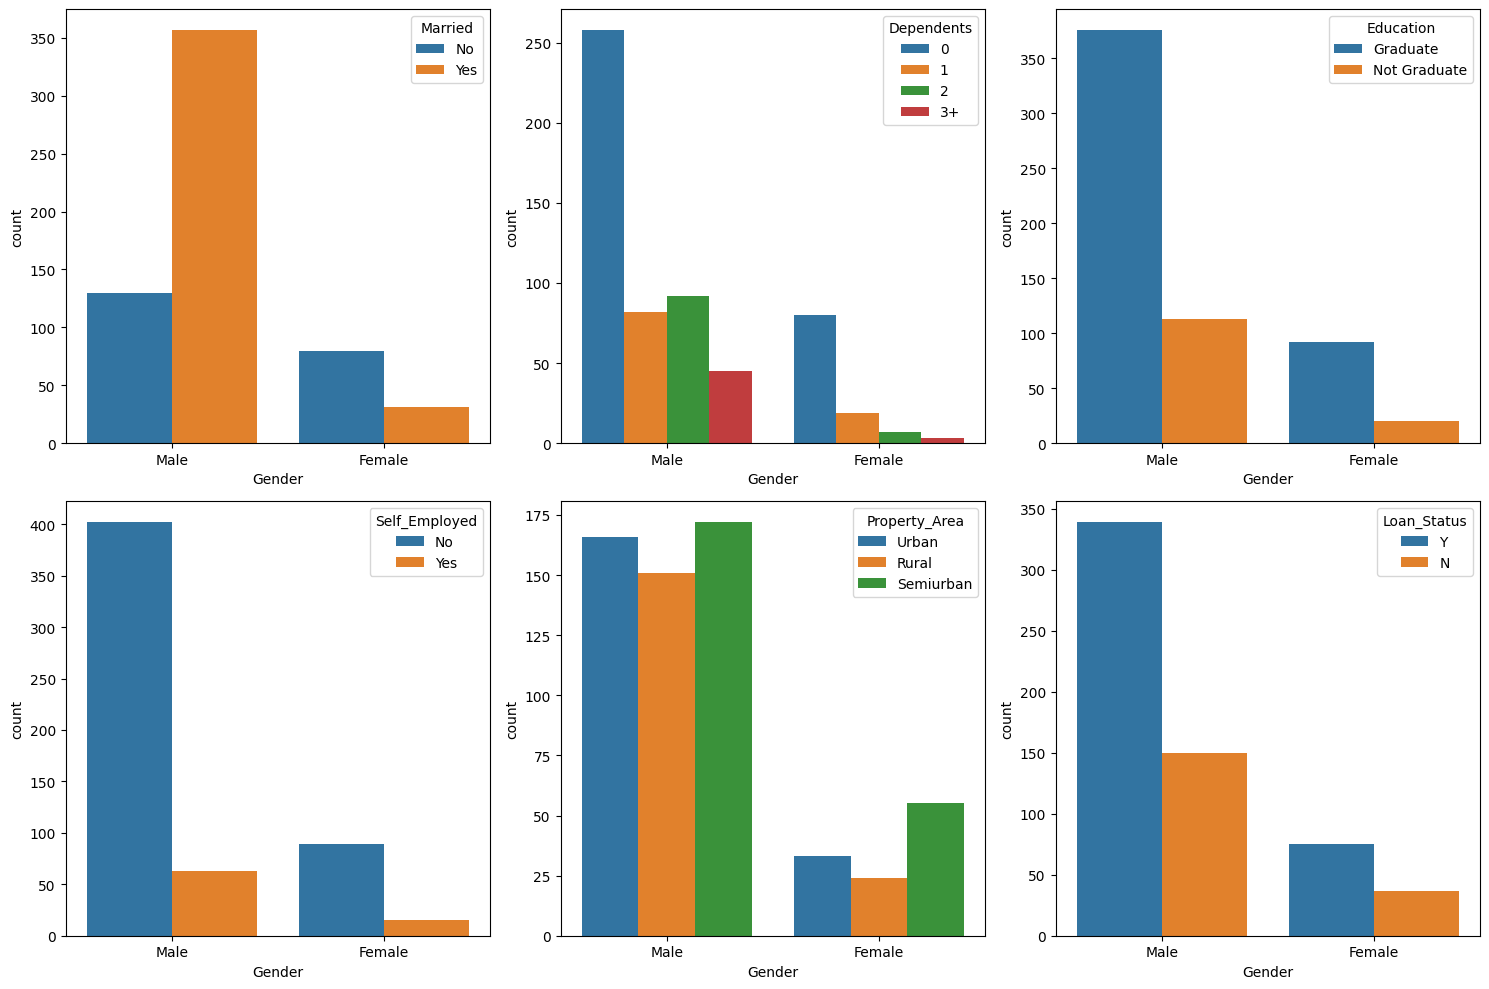

In [8]:
# Visualize the features/columns by showing the counts 
# of observations/rows in each categorical bin. We will use the seaborn package.
data = loan  
# Define plot parameters in a list to avoid repetition
plot_params = [
    ("Married", (0, 0)),
    ("Dependents", (0, 1)),
    ("Education", (0, 2)),
    ("Self_Employed", (1, 0)),
    ("Property_Area", (1, 1)),
    ("Loan_Status", (1, 2))
]
# Create subplots
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

# Loop through plot_params to create the plots
for hue_col, position in plot_params:
    sns.countplot(x="Gender", hue=hue_col, data=data, ax=ax[position])

plt.tight_layout()  # Adjust spacing
plt.show()


You will notice that the sampling between male and
female is unbalanced across the features.
• We will not apply any sampling technique at this
stage. Use the dataset as it is.


<Axes: xlabel='Gender'>

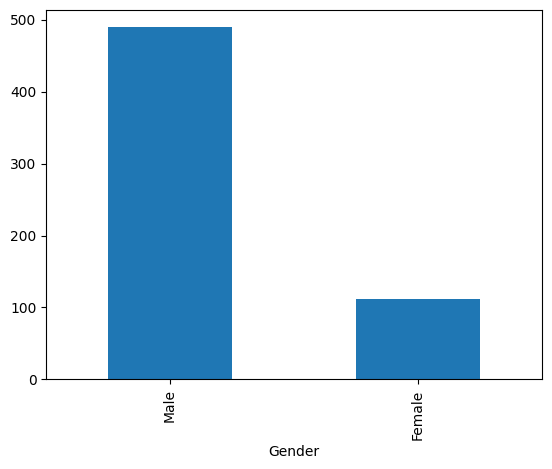

In [9]:
#You can see the frequency of male and female instances with the following:
loan.Gender.value_counts().plot(kind='bar')

In [10]:
#Check for null values and replace them with the mode.
loan["Gender"].fillna(value=loan['Gender'].mode()[0],inplace=True)
loan["Married"].fillna(value=loan['Married'].mode()[0],inplace=True)
loan["Dependents"].fillna(value=loan['Dependents'].mode()[0],inplace=True)
loan["Self_Employed"].fillna(value=loan['Self_Employed'].mode()[0],inplace=True)
loan["LoanAmount"].fillna(value=loan['LoanAmount'].mode()[0],inplace=True)
loan["Loan_Amount_Term"].fillna(value=loan['Loan_Amount_Term'].mode()[0],inplace=True)
loan["Credit_History"].fillna(value=loan['Credit_History'].mode()[0],inplace=True)

In [11]:
# Select categorical columns based on dtype
cat_cols = loan.select_dtypes(include=['object']).columns

# Apply categorical encoding
for col in cat_cols:
    loan[col] = loan[col].astype('category').cat.codes
loan.dtypes

Gender                  int8
Married                 int8
Dependents              int8
Education               int8
Self_Employed           int8
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area           int8
Loan_Status             int8
dtype: object

# Splitting the data

In [12]:
#Create the attribute and target data:
X=loan.drop(columns=['Loan_Status'],axis=1)
Y=loan["Loan_Status"]
X.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,1,0,0,0,0,5849,0.0,120.0,360.0,1.0,2
1,1,1,1,0,0,4583,1508.0,128.0,360.0,1.0,0
2,1,1,0,0,1,3000,0.0,66.0,360.0,1.0,2
3,1,1,0,1,0,2583,2358.0,120.0,360.0,1.0,2
4,1,0,0,0,0,6000,0.0,141.0,360.0,1.0,2


In [13]:
#Split the data into training and test data using train_test_split() function. :
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,
                                               test_size=0.2,
                                               stratify=Y,
                                               random_state=7)
print(X.shape,X_train.shape,X_test.shape)

(614, 11) (491, 11) (123, 11)


In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X),columns=X.columns, index=X.index)
X

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,1.0,0.0,0.000000,0.0,0.0,0.070489,0.000000,0.160637,0.743590,1.0,1.0
1,1.0,1.0,0.333333,0.0,0.0,0.054830,0.036192,0.172214,0.743590,1.0,0.0
2,1.0,1.0,0.000000,0.0,1.0,0.035250,0.000000,0.082489,0.743590,1.0,1.0
3,1.0,1.0,0.000000,1.0,0.0,0.030093,0.056592,0.160637,0.743590,1.0,1.0
4,1.0,0.0,0.000000,0.0,0.0,0.072356,0.000000,0.191027,0.743590,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
609,0.0,0.0,0.000000,0.0,0.0,0.034014,0.000000,0.089725,0.743590,1.0,0.0
610,1.0,1.0,1.000000,0.0,0.0,0.048930,0.000000,0.044863,0.358974,1.0,0.0
611,1.0,1.0,0.333333,0.0,0.0,0.097984,0.005760,0.353111,0.743590,1.0,1.0
612,1.0,1.0,0.666667,0.0,0.0,0.091936,0.000000,0.257598,0.743590,1.0,1.0


# Develop and Evaluate the model

In [15]:
# Create a Gender-Aware SVM model with a linear kernel:
SVM_model = SVC(kernel="linear",
                probability=True).fit(X_train,Y_train)

# Evaluate using the testing data

In [16]:
Y_predict=SVM_model.predict(X_test)

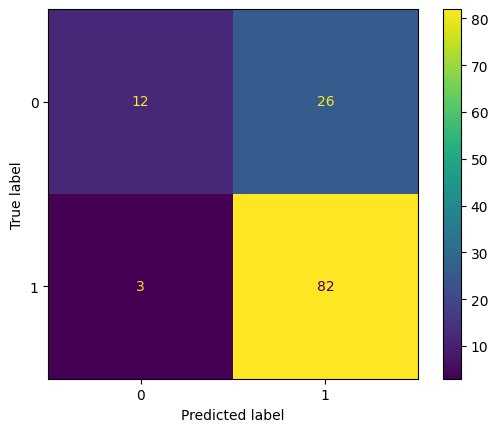

In [17]:
#Display the confusion matrix for your model
cm = confusion_matrix(Y_test, Y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [18]:
TN=12
TP=82
FN=3
FP=26

# Manual Calculation of evaluation metrics

In [19]:
# Calculate the accuracy, precision and recall
calculated_accuracy = (TP+TN)/(TP+TN+FP+FN)
calculated_precision = (TP)/(TP+FP)
calculated_recall = (TP)/(TP+FN)
calculated_F1=2*((calculated_precision * calculated_recall)/(calculated_precision + calculated_recall))

print(f"Calculated accuracy =  {calculated_accuracy*100 :.2f}%")
print(f"Calculated precision = {calculated_precision *100 :.2f}%")
print(f"Calculated recall = {calculated_recall *100 :.2f}%")
print(f"Calculated F1 =  {calculated_F1*100 :.2f}%")

Calculated accuracy =  76.42%
Calculated precision = 75.93%
Calculated recall = 96.47%
Calculated F1 =  84.97%


# Evaluation metrics

In [20]:
print(f"Accuracy: {accuracy_score(Y_test, Y_predict) *100 :.2f}%") 
print(f"Precision: { precision_score(Y_test, Y_predict)*100 :.2f}%")
print(f"Recall :{ recall_score(Y_test, Y_predict)*100 :.2f}%")
print(f"F1: { f1_score(Y_test, Y_predict)*100 :.2f}%")

Accuracy: 76.42%
Precision: 75.93%
Recall :96.47%
F1: 84.97%


# Get the indices for “Male” and “Female” from the test data
- The code below will check the Gender parameter [Protected Characteristics] and extract the indices where the values are 1.0 [Men] and 0.0 [Women]


In [21]:
PROTECTED = "Gender"
MEN = 1.0 #male
WOMEN = 0.0 #women
gender_dist = X_test[PROTECTED].value_counts()
print(gender_dist)


Gender
1    100
0     23
Name: count, dtype: int64


In [22]:
men_indices = np.where(X_test[PROTECTED] == MEN)[0]
women_indices = np.where(X_test[PROTECTED] == WOMEN)[0]


In [23]:
Y_predict

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1], dtype=int8)

In [24]:
print(men_indices)
print("No of Men =", men_indices.size)
print(women_indices)
print("No of Women =", women_indices.size)

[  0   1   3   4   6   7   8   9  10  11  12  13  14  15  16  17  18  20
  21  22  23  25  26  27  28  29  30  31  33  34  35  36  37  38  39  40
  41  42  44  45  46  47  49  51  52  53  54  56  58  59  61  63  64  66
  67  68  69  70  71  72  73  74  75  76  77  78  80  81  82  83  84  85
  87  89  90  91  92  93  94  95  96  97  99 100 101 102 104 106 107 108
 109 112 113 114 115 116 117 119 121 122]
No of Men = 100
[  2   5  19  24  32  43  48  50  55  57  60  62  65  79  86  88  98 103
 105 110 111 118 120]
No of Women = 23


In [25]:
# Extract the actual and predicted outcomes for the two groups
# We will use the indices to split Y_test into two groups (one for Male and one for Female)
Y_test_m = [Y_test.values[i] for i in men_indices]
Y_test_f = [Y_test.values[i] for i in women_indices]
print(Y_test_m)
print(Y_test_f)

[1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1]
[0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0]


In [26]:
# Extract the actual and predicted outcomes for the two groups
# Extract the predicted outcomes for the two groups
# Use the indices to split the predicted values (Y_predict) into two groups
Y_predict_m = [Y_predict[i] for i in men_indices]
Y_predict_f = [Y_predict[i] for i in women_indices]
print(Y_predict_m)
print(Y_predict_f)

[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1]
[0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]


# Compute the confusion matrices (cm_m and cm_f)

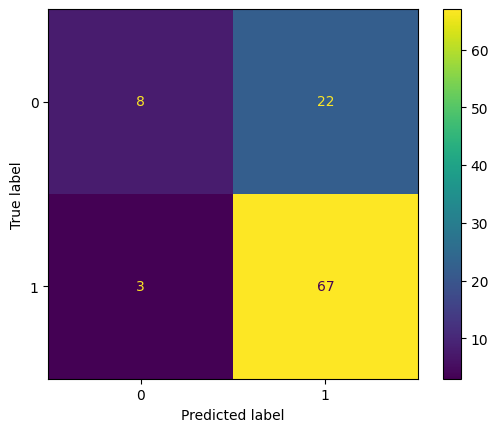

In [27]:
cm_m = confusion_matrix(Y_test_m, Y_predict_m)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_m)
disp.plot()

In [28]:
TN_m=8
TP_m=67
FN_m=3
FP_m=22
# Calculate accuracy, precision, recall, and F1-score for males
calculated_accuracy_m = (TP_m + TN_m) / (TP_m + TN_m + FP_m + FN_m)
calculated_precision_m = TP_m / (TP_m + FP_m)
calculated_recall_m = TP_m / (TP_m + FN_m)
calculated_F1_m = 2 * ((calculated_precision_m * calculated_recall_m) / (calculated_precision_m + calculated_recall_m))

# Print results
print(f"Male Accuracy: {calculated_accuracy_m *100:.3f}")
print(f"Male Precision: {calculated_precision_m*100:.3f}")
print(f"Male Recall: {calculated_recall_m*100:.3f}")
print(f"Male F1 Score: {calculated_F1_m*100:.3f}")

Male Accuracy: 75.000
Male Precision: 75.281
Male Recall: 95.714
Male F1 Score: 84.277


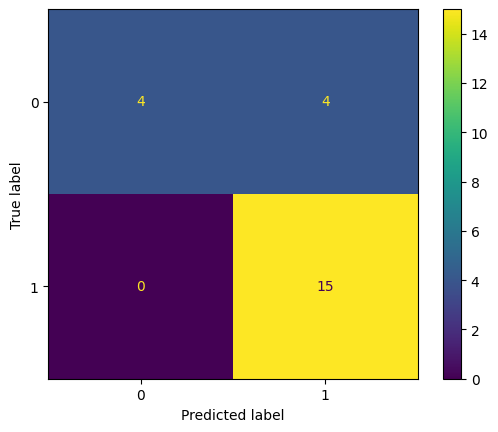

In [29]:
cm_f = confusion_matrix(Y_test_f, Y_predict_f)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_f)
disp.plot()

In [30]:
TN_f=4
TP_f=15
FN_f=0
FP_f=4
# Calculate accuracy, precision, recall, and F1-score for females
calculated_accuracy_f = (TP_f + TN_f) / (TP_f + TN_f + FP_f + FN_f)
calculated_precision_f = TP_f / (TP_f + FP_f)
calculated_recall_f = TP_f / (TP_f + FN_f)
calculated_F1_f = 2 * ((calculated_precision_f * calculated_recall_f) / (calculated_precision_f + calculated_recall_f))

# Print results

print(f"Female Accuracy: {calculated_accuracy_f *100:.3f}")
print(f"Female Precision: {calculated_precision_f *100:.3f}")
print(f"Female Recall: {calculated_recall_f *100:.3f}")
print(f"Female F1 Score: {calculated_F1_f *100:.3f}")

Female Accuracy: 82.609
Female Precision: 78.947
Female Recall: 100.000
Female F1 Score: 88.235


# EXPLAINER WITH LIME

In [31]:
# LIME Explanation
explainer_lime = lime.lime_tabular.LimeTabularExplainer(X_train.values,
                                                        feature_names=X.columns,
                                                        class_names=list(Y.unique()),
                                                        mode="classification")
lime_exp = explainer_lime.explain_instance(X_test.iloc[90].values,
                                           SVM_model.predict_proba)
lime_exp.show_in_notebook()


# EXPLAINER WITH SHAP

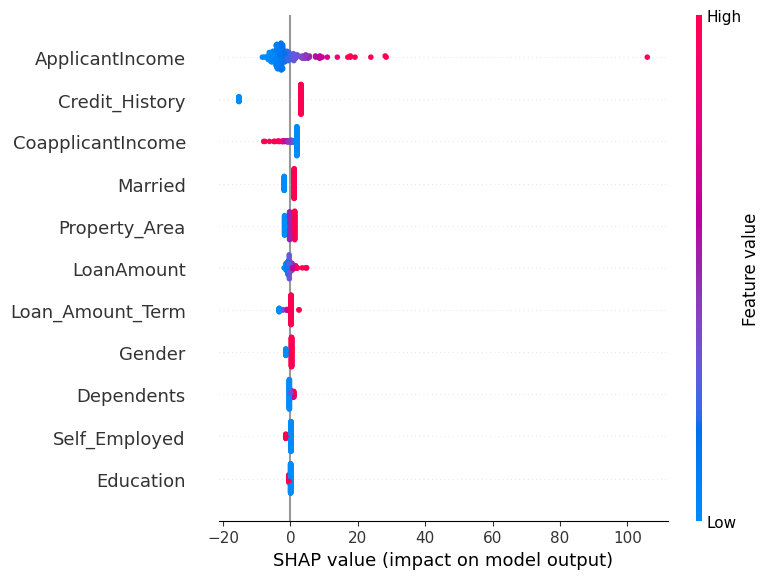

In [32]:
# SHAP Explanation (Fixed)
explainer_shap = shap.Explainer(SVM_model, X_train)
shap_values = explainer_shap(X_test)

# Convert shap_values to correct format for summary plot
shap.summary_plot(shap_values.values, X_test, feature_names=X.columns)


  0%|          | 0/123 [00:00<?, ?it/s]

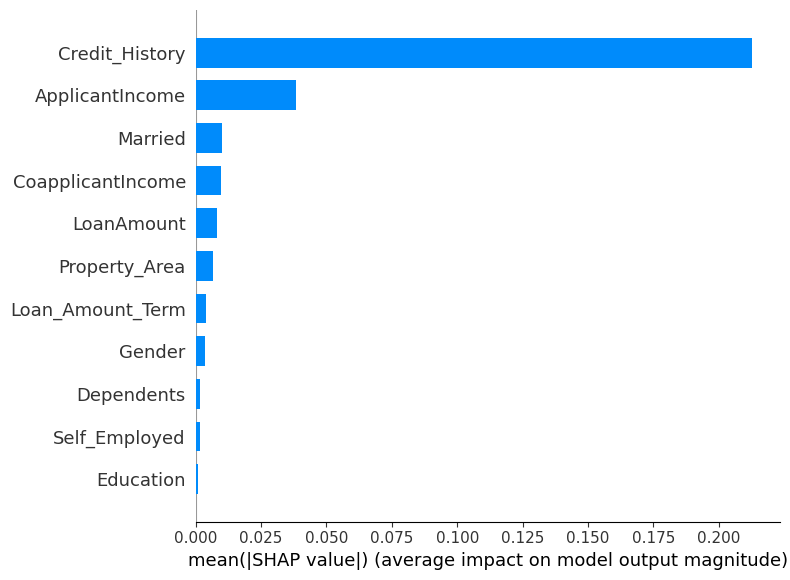

In [38]:
explainer2 = shap.KernelExplainer(SVM_model.predict, shap.sample(X_train, 100))
shap_values2 = explainer2.shap_values(X_test)
# Convert shap_values to correct format for summary plot
shap.summary_plot(shap_values2, X_train, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values2.values, X_train)